In [79]:
import sys
import os

sys.path.append(os.path.abspath('../scripts'))

In [46]:
import pandas as pd

df_rtm = pd.read_csv('../data/Simulated_RTM_Logs.csv')
df_ipdr = pd.read_csv('../data/Simulated_CDR_IPDR_Logs.csv')

df_rtm['timestamp'] = pd.to_datetime(df_rtm['timestamp'])
df_ipdr['timestamp'] = pd.to_datetime(df_ipdr['timestamp'])

df_rtm['date'] = df_rtm['timestamp'].dt.date
df_ipdr['date'] = df_ipdr['timestamp'].dt.date

df_rtm['hour'] = df_rtm['timestamp'].dt.hour
df_ipdr['hour'] = df_ipdr['timestamp'].dt.hour

df_rtm['duration_sec'] = pd.to_numeric(df_rtm['duration_sec'], errors='coerce')
df_ipdr['duration_sec'] = pd.to_numeric(df_ipdr['duration_sec'], errors='coerce')

df_rtm['fraud_label'] = df_rtm['fraud_label'].fillna('Unknown')
df_ipdr['fraud_label'] = df_ipdr['fraud_label'].fillna('Unknown')

df_rtm['hour_bin'] = pd.cut(df_rtm['hour'], 
                            bins=[0, 6, 12, 18, 24], 
                            labels=['Midnight-6AM', '6AM–12PM', '12PM–6PM', '6PM–Midnight'], 
                            right=False)

rtm_summary = df_rtm.groupby(['subscriber_id', 'date', 'hour']).agg(
    app_duration=('duration_sec', 'sum'),
    rtm_fraud_label=('fraud_label', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

ipdr_summary = df_ipdr.groupby(['subscriber_id', 'date', 'hour']).agg(
    cdr_ipdr_duration=('duration_sec', 'sum'),
    ipdr_fraud_label=('fraud_label', lambda x: x.mode().iloc[0] if not x.mode().empty else None)
).reset_index()

bins = [0, 6, 12, 18, 24]
labels = ['00–06', '06–12', '12–18', '18–24']
df_rtm['hour_bin'] = pd.cut(df_rtm['hour'], bins=bins, labels=labels, right=False)

duration_by_time_and_fraud = df_rtm.groupby(['hour_bin', 'fraud_label'])['duration_sec'].sum().unstack(fill_value=0)
duration_by_time_and_fraud


/tmp/ipykernel_12160/1642670177.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_by_time_and_fraud = df_rtm.groupby(['hour_bin', 'fraud_label'])['duration_sec'].sum().unstack(fill_value=0)


fraud_label,Benign,Financial,Identity,Investment,Psychological
hour_bin,,,,,
00–06,114485,4861,13985,6911,4317
06–12,91945,5580,6760,2739,4811
12–18,98223,10334,2447,7634,8579
18–24,85624,6522,6614,8304,7720


In [29]:
# Fraud or not fraud

ipdr_summary['is_fraud'] = ipdr_summary['ipdr_fraud_label'].apply(
    lambda x: 'Fraud' if x != 'Benign' else 'Benign'
)
df_rtm

,subscriber_id,telecom,app,timestamp,duration_sec,fraud_label,date,hour,hour_bin
0,SUB_001,MTNL,WhatsApp,2025-04-01 16:45:00,495,Benign,2025-04-01,16,12PM–6PM
1,SUB_001,MTNL,WhatsApp,2025-04-01 22:05:00,1604,Benign,2025-04-01,22,6PM–Midnight
2,SUB_001,MTNL,WhatsApp,2025-04-01 11:03:00,180,Benign,2025-04-01,11,6AM–12PM
3,SUB_001,MTNL,WhatsApp,2025-04-01 14:15:00,496,Benign,2025-04-01,14,12PM–6PM
4,SUB_001,MTNL,WhatsApp,2025-04-01 00:32:00,113,Benign,2025-04-01,0,Midnight-6AM
...,...,...,...,...,...,...,...,...,...
508,SUB_010,Vi,Signal,2025-04-03 21:03:00,82,Benign,2025-04-03,21,6PM–Midnight
509,SUB_010,Vi,Signal,2025-04-03 15:26:00,571,Benign,2025-04-03,15,12PM–6PM
510,SUB_010,Vi,Signal,2025-04-03 12:53:00,295,Benign,2025-04-03,12,12PM–6PM
511,SUB_010,Vi,Signal,2025-04-03 12:34:00,1742,Benign,2025-04-03,12,12PM–6PM


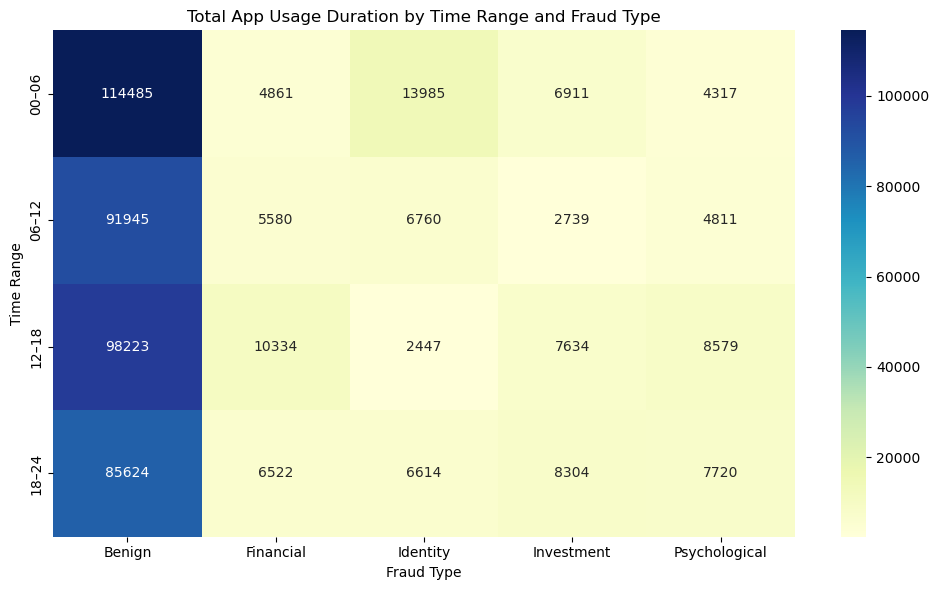

In [41]:
# Count of fraud for each application
app_fraud_counts = df_rtm.pivot_table(
    index='app',
    columns='fraud_label',
    values='subscriber_id',
    aggfunc='count',
    fill_value=0
)

app_fraud_ratios = app_fraud_counts.div(app_fraud_counts.sum(axis=1), axis=0)
app_fraud_ratios
import seaborn as sns
sns.heatmap(app_fraud_ratios, annot=True, cmap="YlGnBu")

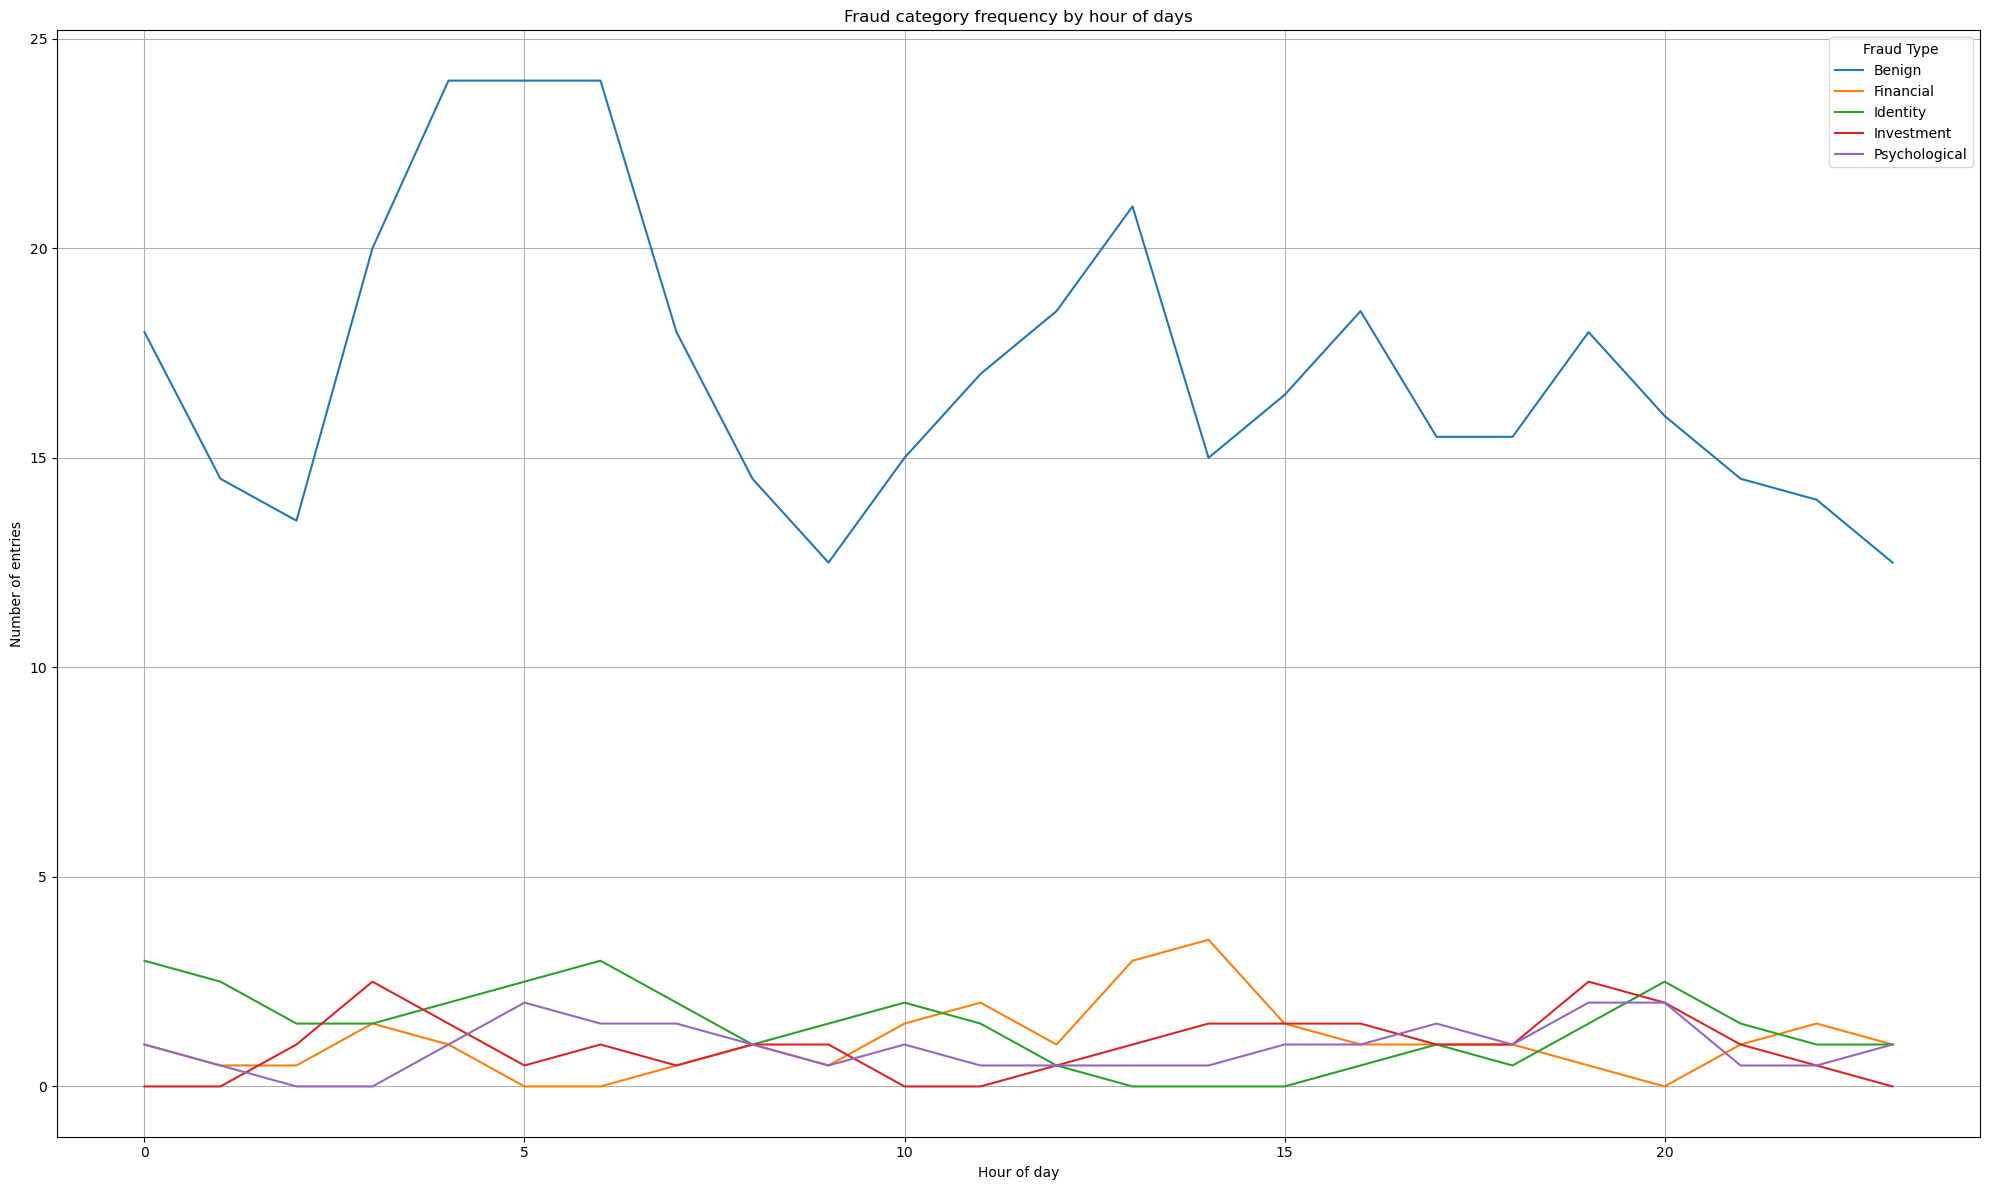

In [43]:
hourly_fraud = df_rtm.pivot_table(
    index='hour',
    columns='fraud_label',
    values='subscriber_id',
    aggfunc='count',
    fill_value=0
).rolling(window=2, min_periods=1, center=True).mean()

import matplotlib.pyplot as plt

hourly_fraud.plot(kind='line', figsize=(20, 12))
plt.title('Fraud category frequency by hour of days')
plt.xlabel('Hour of day')
plt.ylabel('Number of entries')
plt.grid(True)
plt.legend(title='Fraud Type')
plt.tight_layout()
plt.show()

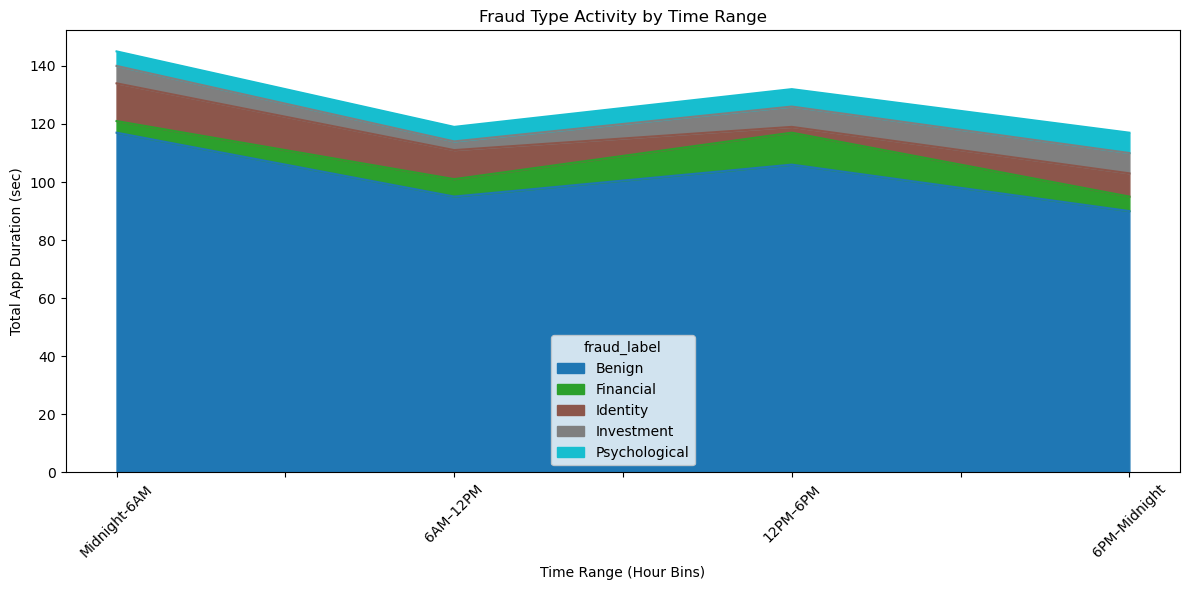

pandas.core.frame.DataFrame

In [39]:
binned_counts.plot(kind='area', stacked=True, colormap='tab10', figsize=(12, 6))
plt.title('Fraud Type Activity by Time Range')
plt.ylabel('Total App Duration (sec)')
plt.xlabel('Time Range (Hour Bins)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
type(binned_counts)

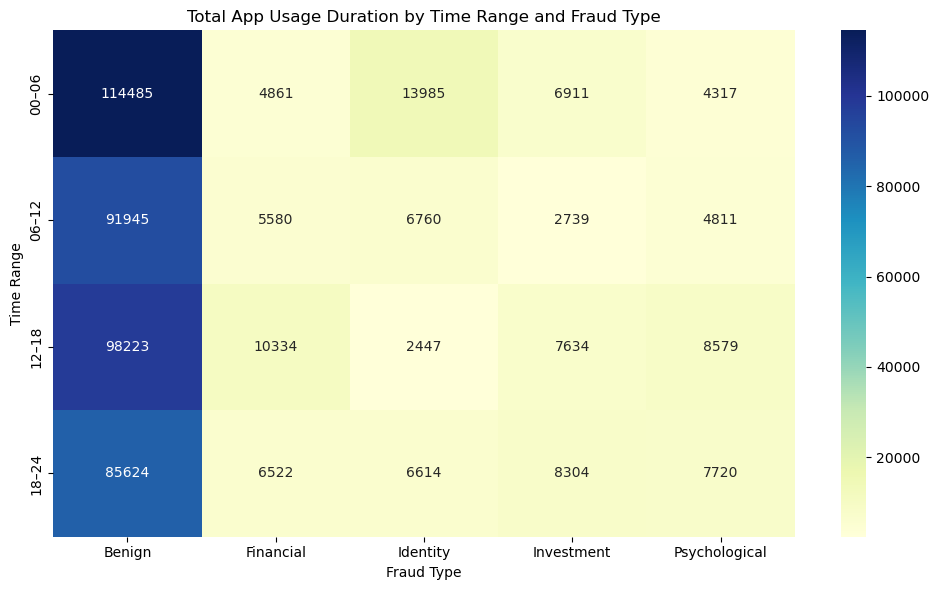

In [44]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(duration_by_time_and_fraud, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Total App Usage Duration by Time Range and Fraud Type")
plt.ylabel("Time Range")
plt.xlabel("Fraud Type")
plt.tight_layout()
plt.show()